In [54]:
import numpy as np
import mlflow
import mlflow.tensorflow
from sqlalchemy import create_engine
from sqlalchemy.engine.base import Engine
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import logging
import shap
import matplotlib.pyplot as plt


logging.basicConfig(level=logging.INFO)

# Data importing functions

In [42]:
def get_db_engine(
    username: str,
    password: str,
    protocol: str = "postgresql",
    server: str = "localhost",
    port: int = 5432,
    dbname: str = "ufc",
) -> Engine:
    engine = create_engine(
        f"{protocol}://{username}:{password}@{server}:{port}/{dbname}",
        isolation_level="AUTOCOMMIT",
    )
    return engine

def get_data(engine: Engine) -> np.ndarray:
    connection = engine.connect()
    result = connection.execute("SELECT * FROM ufc.model_input")
    data = np.array(result.fetchall())
    connection.close()
    return data

def prepare_data(data_np: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    # Drop "fighter1" and "fighter2" columns (assuming they are the first two columns)
    X = data_np[:, 3:]
    
    # Extract the "win" column (assuming it is the third column)
    y = data_np[:, 2]
    
    # Convert all columns in X to float32
    X = X.astype(np.float32)

    # Convert Y to boolean
    y = y.astype(int)
    
    # Perform the split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return X, y, X_train, X_test, y_train, y_test


In [43]:
data = get_data(get_db_engine("postgres", "postgres"))
X, y, X_train, X_test, y_train, y_test = prepare_data(data)

## MLflow config

In [44]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

## Tensorflow model

In [45]:
def train_test_model(hparams, X_train, X_test, y_train, y_test, experiment_name):
    """
    Trains, tests, and logs metrics and model for a deep learning classifier.
    
    Parameters:
        hparams (dict): Hyperparameters for the model.
        X_train (np.ndarray): Training features.
        X_test (np.ndarray): Testing features.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Testing labels.
        
    Returns:
        float: Test accuracy of the model.
    """
    logging.info("Starting training run...")

    # Standardize the features
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run() as run:
        
        # Log hyperparameters
        logging.info(f"Logging hyperparameters: {hparams}")
        mlflow.log_params(hparams)
        
        # Model architecture
        logging.info("Building model...")
        model = models.Sequential([
            layers.Dense(hparams["num_units"], activation='relu'),
            layers.Dropout(hparams["dropout"]),
            layers.Dense(1, activation='sigmoid'),
        ])
        
        model.compile(
            optimizer=hparams["optimizer"],
            loss='binary_crossentropy',
            metrics=['accuracy'],
        )
        
        # Train model and capture history
        logging.info("Training model...")
        history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
        
        # Log training accuracy
        train_accuracy = history.history['accuracy'][-1]  # Taking the final epoch accuracy
        logging.info(f"Logging training accuracy: {train_accuracy}")
        mlflow.log_metric("train_accuracy", train_accuracy)
        
        # Evaluate model
        logging.info("Evaluating model...")
        _, test_accuracy = model.evaluate(X_test, y_test)
        
        # Log test accuracy
        logging.info(f"Logging test accuracy: {test_accuracy}")
        mlflow.log_metric("test_accuracy", test_accuracy)
        
        # Predict probabilities and calculate ROC AUC
        logging.info("Calculating and logging ROC AUC...")
        y_probs = model.predict(X_test)
        roc_auc = roc_auc_score(y_test, y_probs)
        
        # Log ROC AUC
        mlflow.log_metric("roc_auc", roc_auc)
        
        # Log model
        logging.info("Logging model to MLflow...")
        mlflow.tensorflow.log_model(model, "model")
        
    logging.info("Training run completed.")
    
    return test_accuracy

First we test the following 4 hyperparameter sets to get an idea for using neural nets in the problems context

In [46]:
hyperparameters_list = [
    {"num_units": 16, "dropout": 0.1, "optimizer": 'adam'},
    {"num_units": 32, "dropout": 0.1, "optimizer": 'adam'},
    {"num_units": 16, "dropout": 0.2, "optimizer": 'adam'},
    {"num_units": 16, "dropout": 0.1, "optimizer": 'sgd'},
]

for hparams in hyperparameters_list:
    accuracy = train_test_model(hparams, X_train, X_test, y_train, y_test, "Neural Network hyperparameter tuning")
    print("Accuracy:", accuracy)


INFO:root:Starting training run...
2023/10/25 21:43:42 INFO mlflow.tracking.fluent: Experiment with name 'Neural Network hyperparameter tuning' does not exist. Creating a new experiment.
INFO:root:Logging hyperparameters: {'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
INFO:root:Building model...
INFO:root:Training model...


Epoch 1/10
141/141 [==============================] - 2s 6ms/step - loss: 0.7439 - accuracy: 0.5409 - val_loss: 0.6522 - val_accuracy: 0.5963
Epoch 2/10
141/141 [==============================] - 1s 5ms/step - loss: 0.6147 - accuracy: 0.6638 - val_loss: 0.5943 - val_accuracy: 0.6649
Epoch 3/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5778 - accuracy: 0.6986 - val_loss: 0.5701 - val_accuracy: 0.7068
Epoch 4/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5593 - accuracy: 0.7139 - val_loss: 0.5586 - val_accuracy: 0.7184
Epoch 5/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5482 - accuracy: 0.7217 - val_loss: 0.5521 - val_accuracy: 0.7255
Epoch 6/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5465 - accuracy: 0.7284 - val_loss: 0.5474 - val_accuracy: 0.7291
Epoch 7/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5389 - accuracy: 0.7302 - val_loss: 0.5456 - val_accuracy: 0.7353
Epoch 

INFO:root:Logging training accuracy: 0.7411371469497681
INFO:root:Evaluating model...


36/36 [==============================] - 0s 5ms/step - loss: 0.5402 - accuracy: 0.7380


INFO:root:Logging test accuracy: 0.7379679083824158
INFO:root:Calculating and logging ROC AUC...


36/36 [==============================] - 0s 3ms/step


INFO:root:Logging model to MLflow...
2023/10/25 21:43:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpwbimuu2x/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpwbimuu2x/model/data/model/assets
Setuptools is replacing distutils.
INFO:root:Training run completed.
INFO:root:Starting training run...
INFO:root:Logging hyperparameters: {'num_units': 32, 'dropout': 0.1, 'optimizer': 'adam'}
INFO:root:Building model...
INFO:root:Training model...


Accuracy: 0.7379679083824158
Epoch 1/10
141/141 [==============================] - 2s 7ms/step - loss: 0.6479 - accuracy: 0.6214 - val_loss: 0.5821 - val_accuracy: 0.7077
Epoch 2/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5712 - accuracy: 0.7030 - val_loss: 0.5581 - val_accuracy: 0.7201
Epoch 3/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5548 - accuracy: 0.7233 - val_loss: 0.5502 - val_accuracy: 0.7291
Epoch 4/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5404 - accuracy: 0.7367 - val_loss: 0.5487 - val_accuracy: 0.7299
Epoch 5/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5326 - accuracy: 0.7371 - val_loss: 0.5445 - val_accuracy: 0.7273
Epoch 6/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5293 - accuracy: 0.7438 - val_loss: 0.5417 - val_accuracy: 0.7317
Epoch 7/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5268 - accuracy: 0.7423 - val_loss: 0.5415 

INFO:root:Logging training accuracy: 0.7449275255203247
INFO:root:Evaluating model...


36/36 [==============================] - 0s 5ms/step - loss: 0.5411 - accuracy: 0.7291


INFO:root:Logging test accuracy: 0.7290552854537964
INFO:root:Calculating and logging ROC AUC...


36/36 [==============================] - 0s 5ms/step


INFO:root:Logging model to MLflow...
2023/10/25 21:44:10 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp76ey6w10/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp76ey6w10/model/data/model/assets
INFO:root:Training run completed.
INFO:root:Starting training run...
INFO:root:Logging hyperparameters: {'num_units': 16, 'dropout': 0.2, 'optimizer': 'adam'}
INFO:root:Building model...
INFO:root:Training model...


Accuracy: 0.7290552854537964
Epoch 1/10
141/141 [==============================] - 2s 7ms/step - loss: 0.7056 - accuracy: 0.5690 - val_loss: 0.6442 - val_accuracy: 0.6221
Epoch 2/10
141/141 [==============================] - 1s 5ms/step - loss: 0.6222 - accuracy: 0.6526 - val_loss: 0.6029 - val_accuracy: 0.6729
Epoch 3/10
141/141 [==============================] - 1s 6ms/step - loss: 0.5939 - accuracy: 0.6829 - val_loss: 0.5829 - val_accuracy: 0.7050
Epoch 4/10
141/141 [==============================] - 1s 6ms/step - loss: 0.5774 - accuracy: 0.6959 - val_loss: 0.5691 - val_accuracy: 0.7228
Epoch 5/10
141/141 [==============================] - 1s 6ms/step - loss: 0.5732 - accuracy: 0.7035 - val_loss: 0.5628 - val_accuracy: 0.7219
Epoch 6/10
141/141 [==============================] - 1s 6ms/step - loss: 0.5628 - accuracy: 0.7142 - val_loss: 0.5563 - val_accuracy: 0.7264
Epoch 7/10
141/141 [==============================] - 1s 6ms/step - loss: 0.5550 - accuracy: 0.7240 - val_loss: 0.5510 

INFO:root:Logging training accuracy: 0.7373467087745667
INFO:root:Evaluating model...


36/36 [==============================] - 0s 5ms/step - loss: 0.5456 - accuracy: 0.7291


INFO:root:Logging test accuracy: 0.7290552854537964
INFO:root:Calculating and logging ROC AUC...


36/36 [==============================] - 0s 5ms/step


INFO:root:Logging model to MLflow...
2023/10/25 21:44:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpip7j6fp3/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpip7j6fp3/model/data/model/assets
INFO:root:Training run completed.
INFO:root:Starting training run...
INFO:root:Logging hyperparameters: {'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd'}
INFO:root:Building model...
INFO:root:Training model...


Accuracy: 0.7290552854537964
Epoch 1/10
141/141 [==============================] - 2s 10ms/step - loss: 0.7318 - accuracy: 0.5527 - val_loss: 0.6648 - val_accuracy: 0.6078
Epoch 2/10
141/141 [==============================] - 1s 8ms/step - loss: 0.6427 - accuracy: 0.6321 - val_loss: 0.6193 - val_accuracy: 0.6631
Epoch 3/10
141/141 [==============================] - 1s 7ms/step - loss: 0.6058 - accuracy: 0.6725 - val_loss: 0.5986 - val_accuracy: 0.6898
Epoch 4/10
141/141 [==============================] - 1s 7ms/step - loss: 0.5861 - accuracy: 0.6948 - val_loss: 0.5870 - val_accuracy: 0.6952
Epoch 5/10
141/141 [==============================] - 1s 6ms/step - loss: 0.5726 - accuracy: 0.7079 - val_loss: 0.5785 - val_accuracy: 0.6988
Epoch 6/10
141/141 [==============================] - 1s 7ms/step - loss: 0.5678 - accuracy: 0.7115 - val_loss: 0.5740 - val_accuracy: 0.7023
Epoch 7/10
141/141 [==============================] - 1s 6ms/step - loss: 0.5652 - accuracy: 0.7133 - val_loss: 0.5694

INFO:root:Logging training accuracy: 0.7264214158058167
INFO:root:Evaluating model...


36/36 [==============================] - 0s 4ms/step - loss: 0.5611 - accuracy: 0.7103


INFO:root:Logging test accuracy: 0.7103386521339417
INFO:root:Calculating and logging ROC AUC...


36/36 [==============================] - 0s 5ms/step


INFO:root:Logging model to MLflow...
2023/10/25 21:44:55 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmptq7jwys_/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmptq7jwys_/model/data/model/assets
INFO:root:Training run completed.


Accuracy: 0.7103386521339417


In [47]:
import pandas as pd

def summarize_mlflow_runs(experiment_name, metrics_to_include):
    """
    Summarize MLflow runs for a given experiment.

    Parameters:
    - experiment_name: Name of the MLflow experiment.

    Returns:
    - summary_df: DataFrame summarizing the runs.
    """

    # Set the MLflow experiment
    mlflow.set_experiment(experiment_name)

    # Fetch all runs from the MLflow experiment
    runs = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id])

    # Create an empty summary DataFrame
    summary_df = pd.DataFrame(columns=["Model"] + metrics_to_include)

    # Iterate through the runs and extract relevant metrics
    for _, run in runs.iterrows():
        model_name = run["tags.mlflow.runName"]
        metrics = [run[f"metrics.{metric}"] for metric in metrics_to_include]

        # Append metrics to the summary DataFrame
        summary_df.loc[len(summary_df)] = [model_name] + metrics

    # Sort the summary DataFrame by the desired metric (e.g., ROC AUC)
    sorted_summary_df = summary_df.sort_values(by=f"{metrics_to_include[2]}", ascending=False)

    return sorted_summary_df

In [48]:
metrics_to_include = ["train_accuracy", "test_accuracy", "roc_auc"]
experiment_name = "Neural Network hyperparameter tuning"
summary_df = summarize_mlflow_runs(experiment_name, metrics_to_include)
print("Performance Summary Table (Sorted by ROC AUC)")
print(summary_df.head())

Performance Summary Table (Sorted by ROC AUC)
                 Model  train_accuracy  test_accuracy   roc_auc
3    orderly-midge-728        0.741137       0.737968  0.806412
2      spiffy-lynx-377        0.744928       0.729055  0.804536
1      nimble-toad-539        0.737347       0.729055  0.799797
0  thundering-slug-666        0.726421       0.710339  0.782542


To get an even better idea of the test accuracy, lets do some cross validation

In [50]:
def train_test_models(hyperparameters_list, X, y, experiment_name, n_splits=5):
    """
    Trains, tests, and logs metrics and models for a deep learning classifier using k-fold cross-validation.
    This function performs the training for multiple hyperparameter sets.
    
    Parameters:
        hyperparameters_list (list of dict): List of hyperparameter dictionaries.
        X (np.ndarray): Features.
        y (np.ndarray): Labels.
        experiment_name (str): Name of the MLflow experiment.
        n_splits (int): Number of folds in k-fold cross-validation.
        
    Returns:
        None
    """
    
    mlflow.set_experiment(experiment_name)
    
    kfold = KFold(n_splits=n_splits)

    for hparams in hyperparameters_list:
        logging.info(f"Starting k-fold training runs for hyperparameters: {hparams}")

        # Initialize lists to store metrics for each fold
        train_accuracy_list = []
        test_accuracy_list = []
        roc_auc_list = []
        
        for train_index, test_index in kfold.split(X):
            # Split the data
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # Standardize the features
            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
                
            # Model architecture
            model = models.Sequential([
                layers.Dense(hparams["num_units"], activation='relu'),
                layers.Dropout(hparams["dropout"]),
                layers.Dense(1, activation='sigmoid'),
            ])
                
            model.compile(
                optimizer=hparams["optimizer"],
                loss='binary_crossentropy',
                metrics=['accuracy'],
            )
                
            # Train model and capture history
            history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
                
            # Store training accuracy
            train_accuracy = history.history['accuracy'][-1]
            train_accuracy_list.append(train_accuracy)
                
            # Evaluate and store test accuracy
            _, test_accuracy = model.evaluate(X_test, y_test)
            test_accuracy_list.append(test_accuracy)
                
            # Calculate and store ROC AUC
            y_probs = model.predict(X_test)
            roc_auc = roc_auc_score(y_test, y_probs)
            roc_auc_list.append(roc_auc)
       
        with mlflow.start_run() as run:
            # Log hyperparameters
            mlflow.log_params(hparams)
    
            # Log average metrics
            mlflow.log_metric("avg_train_accuracy", np.mean(train_accuracy_list))
            mlflow.log_metric("avg_test_accuracy", np.mean(test_accuracy_list))
            mlflow.log_metric("avg_roc_auc", np.mean(roc_auc_list))
        
        mlflow.end_run()

        logging.info(f"k-fold training runs completed for hyperparameters: {hparams}")


In [51]:
hyperparameters_list = [
    {"num_units": 16, "dropout": 0.1, "optimizer": 'adam'},
    {"num_units": 32, "dropout": 0.1, "optimizer": 'adam'},
    {"num_units": 16, "dropout": 0.2, "optimizer": 'adam'},
    {"num_units": 16, "dropout": 0.1, "optimizer": 'sgd'},
]

train_test_models(hyperparameters_list, X, y, "Neural Network hyperparameter tuning, with cross-validation")

2023/10/25 21:46:52 INFO mlflow.tracking.fluent: Experiment with name 'Neural Network hyperparameter tuning, with cross-validation' does not exist. Creating a new experiment.
INFO:root:Starting k-fold training runs for hyperparameters: {'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}


Epoch 1/10
141/141 [==============================] - 2s 5ms/step - loss: 0.7409 - accuracy: 0.5376 - val_loss: 0.6182 - val_accuracy: 0.6604
Epoch 2/10
141/141 [==============================] - 1s 4ms/step - loss: 0.6148 - accuracy: 0.6687 - val_loss: 0.5770 - val_accuracy: 0.7050
Epoch 3/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5840 - accuracy: 0.6970 - val_loss: 0.5619 - val_accuracy: 0.7210
Epoch 4/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5646 - accuracy: 0.7108 - val_loss: 0.5543 - val_accuracy: 0.7255
Epoch 5/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5582 - accuracy: 0.7175 - val_loss: 0.5505 - val_accuracy: 0.7291
Epoch 6/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5515 - accuracy: 0.7233 - val_loss: 0.5470 - val_accuracy: 0.7380
Epoch 7/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5444 - accuracy: 0.7311 - val_loss: 0.5464 - val_accuracy: 0.7460
Epoch 

INFO:root:k-fold training runs completed for hyperparameters: {'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
INFO:root:Starting k-fold training runs for hyperparameters: {'num_units': 32, 'dropout': 0.1, 'optimizer': 'adam'}


Epoch 1/10
141/141 [==============================] - 2s 5ms/step - loss: 0.6752 - accuracy: 0.5902 - val_loss: 0.5842 - val_accuracy: 0.6872
Epoch 2/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5693 - accuracy: 0.7043 - val_loss: 0.5505 - val_accuracy: 0.7255
Epoch 3/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5474 - accuracy: 0.7255 - val_loss: 0.5458 - val_accuracy: 0.7326
Epoch 4/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5361 - accuracy: 0.7400 - val_loss: 0.5446 - val_accuracy: 0.7344
Epoch 5/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5298 - accuracy: 0.7429 - val_loss: 0.5444 - val_accuracy: 0.7389
Epoch 6/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5292 - accuracy: 0.7440 - val_loss: 0.5450 - val_accuracy: 0.7380
Epoch 7/10
141/141 [==============================] - 1s 4ms/step - loss: 0.5240 - accuracy: 0.7469 - val_loss: 0.5459 - val_accuracy: 0.7362
Epoch 

INFO:root:k-fold training runs completed for hyperparameters: {'num_units': 32, 'dropout': 0.1, 'optimizer': 'adam'}
INFO:root:Starting k-fold training runs for hyperparameters: {'num_units': 16, 'dropout': 0.2, 'optimizer': 'adam'}


Epoch 1/10
141/141 [==============================] - 2s 5ms/step - loss: 0.7276 - accuracy: 0.5347 - val_loss: 0.6363 - val_accuracy: 0.6301
Epoch 2/10
141/141 [==============================] - 1s 4ms/step - loss: 0.6305 - accuracy: 0.6337 - val_loss: 0.5922 - val_accuracy: 0.6907
Epoch 3/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5928 - accuracy: 0.6769 - val_loss: 0.5733 - val_accuracy: 0.7023
Epoch 4/10
141/141 [==============================] - 1s 6ms/step - loss: 0.5711 - accuracy: 0.6919 - val_loss: 0.5628 - val_accuracy: 0.7193
Epoch 5/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5583 - accuracy: 0.7119 - val_loss: 0.5564 - val_accuracy: 0.7308
Epoch 6/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5511 - accuracy: 0.7224 - val_loss: 0.5523 - val_accuracy: 0.7335
Epoch 7/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5480 - accuracy: 0.7262 - val_loss: 0.5495 - val_accuracy: 0.7415
Epoch 

INFO:root:k-fold training runs completed for hyperparameters: {'num_units': 16, 'dropout': 0.2, 'optimizer': 'adam'}
INFO:root:Starting k-fold training runs for hyperparameters: {'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd'}


Epoch 1/10
141/141 [==============================] - 3s 11ms/step - loss: 0.7213 - accuracy: 0.5534 - val_loss: 0.6378 - val_accuracy: 0.6506
Epoch 2/10
141/141 [==============================] - 1s 7ms/step - loss: 0.6550 - accuracy: 0.6100 - val_loss: 0.6116 - val_accuracy: 0.6640
Epoch 3/10
141/141 [==============================] - 1s 6ms/step - loss: 0.6193 - accuracy: 0.6589 - val_loss: 0.5965 - val_accuracy: 0.6881
Epoch 4/10
141/141 [==============================] - 1s 7ms/step - loss: 0.5998 - accuracy: 0.6803 - val_loss: 0.5857 - val_accuracy: 0.6952
Epoch 5/10
141/141 [==============================] - 1s 7ms/step - loss: 0.5908 - accuracy: 0.6881 - val_loss: 0.5787 - val_accuracy: 0.7023
Epoch 6/10
141/141 [==============================] - 1s 7ms/step - loss: 0.5842 - accuracy: 0.6981 - val_loss: 0.5734 - val_accuracy: 0.7068
Epoch 7/10
141/141 [==============================] - 1s 7ms/step - loss: 0.5758 - accuracy: 0.7032 - val_loss: 0.5693 - val_accuracy: 0.7112
Epoch

INFO:root:k-fold training runs completed for hyperparameters: {'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd'}


In [52]:
metrics_to_include = ['avg_train_accuracy', 'avg_test_accuracy', 'avg_roc_auc']
experiment_name = "Neural Network hyperparameter tuning, with cross-validation"
summary_df = summarize_mlflow_runs(experiment_name, metrics_to_include)
print("Performance Summary Table (Sorted by ROC AUC)")
print(summary_df.head())

Performance Summary Table (Sorted by ROC AUC)
                Model  avg_train_accuracy  avg_test_accuracy  avg_roc_auc
2   skittish-crow-296            0.748529           0.736940     0.810266
1      capable-bat-10            0.736089           0.740150     0.808858
3     clumsy-fawn-326            0.740949           0.741577     0.808606
0  handsome-quail-684            0.708802           0.705903     0.778725


Alright, the model just seem to be exceptionally good. We do have to keep in mind again though, that we use features that contain perfect information, i.e., the input features of the fighters contain their career statistics at the end of their career.
## SHAP analysis
First retrain the model based on the best performance

In [59]:
# Set the experiment name to get the experiment ID
experiment_name = "Neural Network hyperparameter tuning, with cross-validation"
mlflow.set_experiment(experiment_name)

# Query past runs to find the best run
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
best_run = mlflow.search_runs(
    experiment_ids=[experiment_id], 
    order_by=["metrics.avg_roc_auc DESC"]
).iloc[0]

# Extract the best hyperparameters into a dictionary
best_hparams_dict = {
    "num_units": int(best_run["params.num_units"]),  # Convert to the appropriate data type
    "dropout": float(best_run["params.dropout"]),
    "optimizer": best_run["params.optimizer"]
}

model = models.Sequential([
    layers.Dense(best_hparams_dict["num_units"], activation='relu'),
    layers.Dropout(best_hparams_dict["dropout"]),
    layers.Dense(1, activation='sigmoid'),
])
                
model.compile(
    optimizer=best_hparams_dict["optimizer"],
    loss='binary_crossentropy',
    metrics=['accuracy'],
)
                
# Standardize the features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train model 
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
141/141 [==============================] - 2s 7ms/step - loss: 0.6361 - accuracy: 0.6406 - val_loss: 0.5800 - val_accuracy: 0.6961
Epoch 2/30
141/141 [==============================] - 1s 5ms/step - loss: 0.5712 - accuracy: 0.7090 - val_loss: 0.5561 - val_accuracy: 0.7121
Epoch 3/30
141/141 [==============================] - 1s 5ms/step - loss: 0.5484 - accuracy: 0.7282 - val_loss: 0.5455 - val_accuracy: 0.7246
Epoch 4/30
141/141 [==============================] - 1s 6ms/step - loss: 0.5390 - accuracy: 0.7342 - val_loss: 0.5415 - val_accuracy: 0.7291
Epoch 5/30
141/141 [==============================] - 1s 4ms/step - loss: 0.5368 - accuracy: 0.7420 - val_loss: 0.5412 - val_accuracy: 0.7273
Epoch 6/30
141/141 [==============================] - 1s 5ms/step - loss: 0.5328 - accuracy: 0.7420 - val_loss: 0.5399 - val_accuracy: 0.7237
Epoch 7/30
141/141 [==============================] - 1s 5ms/step - loss: 0.5317 - accuracy: 0.7409 - val_loss: 0.5407 - val_accuracy: 0.7273
Epoch 

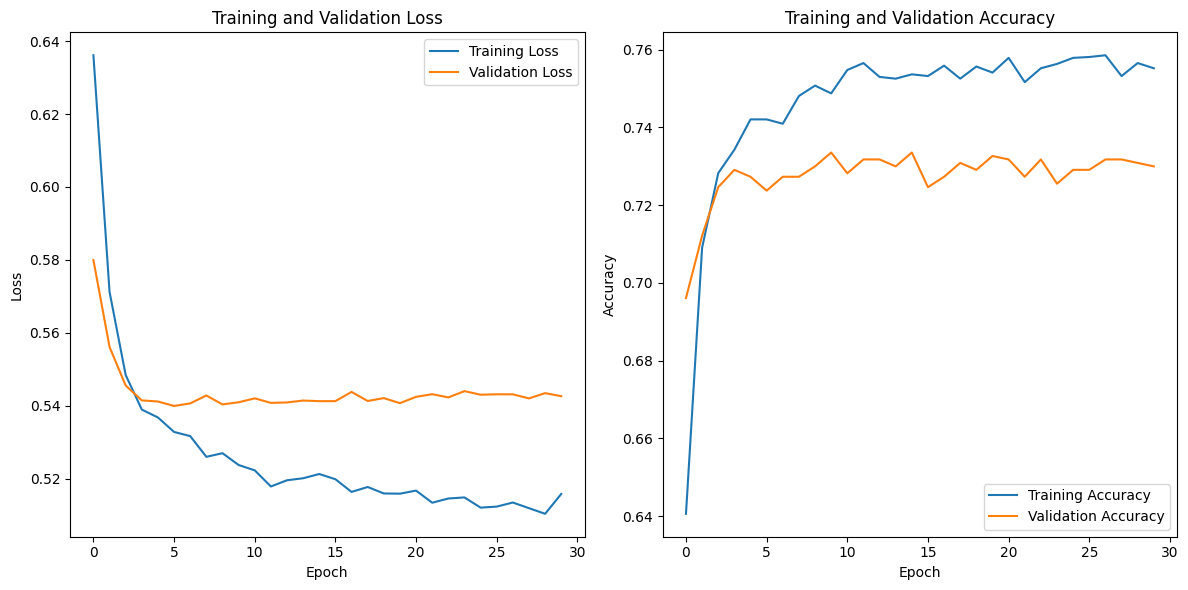

In [60]:
# Plot training loss and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Perform SHAP analysis
explainer = shap.Explainer(model, X_train)  # Create a SHAP explainer
shap_values = explainer(X_train)  # Calculate SHAP values

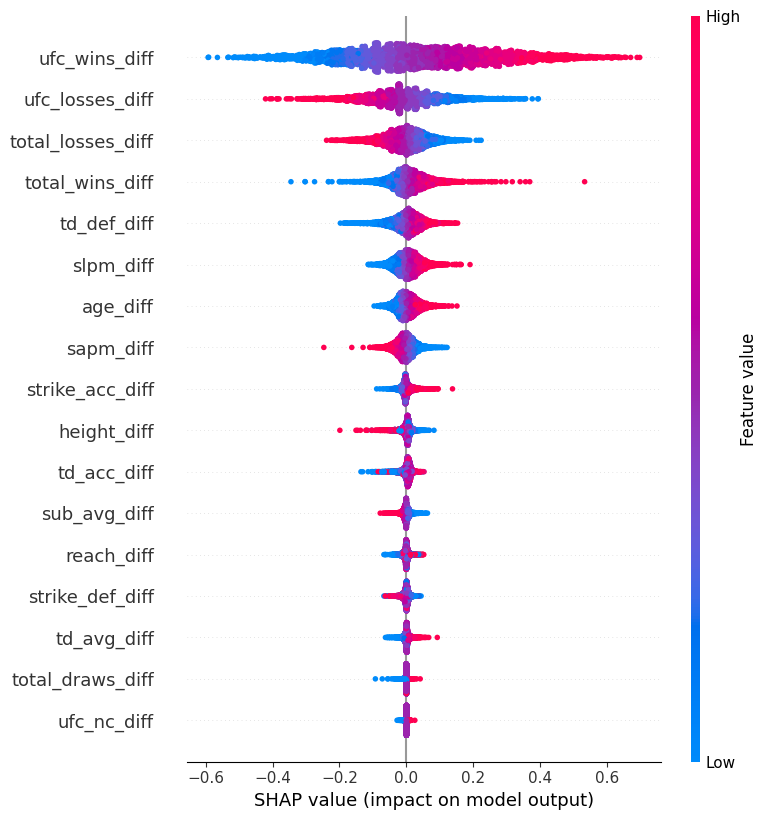

In [58]:
feature_names = [
    'reach_diff',
    'height_diff',
    'age_diff',
    'slpm_diff',
    'td_avg_diff',
    'strike_acc_diff',
    'td_acc_diff',
    'sapm_diff',
    'td_def_diff',
    'strike_def_diff',
    'sub_avg_diff',
    'total_wins_diff',
    'total_losses_diff',
    'total_draws_diff',
    'ufc_wins_diff',
    'ufc_losses_diff',
    'ufc_nc_diff'
]

shap.summary_plot(shap_values, X_train, feature_names=feature_names)

From the SHAP values we can see that the paramters at least make sense, as a higher difference in ufc_wins reflects a higher winning rate. Meanwhile, less ufc losses reflects a higher win rate as well. 

# Save the model

In [1]:
# Write the model to disk so we can use it later
model.save("mlartifacts/DL_model/model.h5")

NameError: name 'model' is not defined